In [1]:
# default_exp collation

# Outage Data Collation

<br>

### Imports

In [2]:
import json
import numpy as np
import pandas as pd
import geopandas as gpd

from outage import retrieval

import matplotlib.pyplot as plt

import os
import requests
from warnings import warn
from jinja2 import Template

from ipypb import track
from IPython.display import JSON

In [3]:
#exports
def collate_cleaned_incidents_info(dnos=['ukpn', 'ssen', 'wpd', 'sp', 'np']):
    cleaned_incidents_info = dict()

    for dno in track(dnos, label='DNOs'):
        raw_dno_incidents_info, cleaned_dno_incidents_info = getattr(retrieval, f'get_{dno}_incidents_info')()
        cleaned_incidents_info[dno] = cleaned_dno_incidents_info
        retrieval.save_json_data(raw_dno_incidents_info, f'{dno}_incidents_info')
        
    return cleaned_incidents_info

In [4]:
cleaned_incidents_info = collate_cleaned_incidents_info()

JSON([cleaned_incidents_info])

           DNOs [█████████████████████████████████████████████] 5/5 [01:08<00:07, 13.55s/it]

   Multiple Ids [█████████████████████████████████████████████] 15/15 [00:06<00:00, 0.39s/it]

        Details [█████████████████████████████████████████████] 119/119 [00:48<00:00, 0.40s/it]

C:\Users\Ayrto\anaconda3\envs\outage\lib\site-packages\urllib3\connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.ssen.co.uk'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


 [████████████████████████████████████████████████████████████] 8/8 [00:00<00:00, 0.00s/it]

c:\users\ayrto\desktop\side projects\outage-watch\outage\retrieval.py:235: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 235 of the file c:\users\ayrto\desktop\side projects\outage-watch\outage\retrieval.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  soup = bs(r.text)


<IPython.core.display.JSON object>

In [5]:
#exports
def get_combined_outages_df(cleaned_incidents_info):
    df_outages = pd.DataFrame()

    for dno, dno_outages in cleaned_incidents_info.items():
        df_dno_outages = pd.DataFrame(dno_outages).T.query('incident_active==True')

        df_dno_outages['dno'] = dno
        df_dno_outages = df_dno_outages[['received_time', 'estimated_restored_time', 'postcodes_impacted', 'description', 'dno', 'incident_url']]

        df_dno_outages.index.name = 'incident_id'
        df_dno_outages = df_dno_outages.reset_index()

        df_outages = df_outages.append(df_dno_outages)

    df_outages = df_outages.reset_index(drop=True)
    
    return df_outages

In [6]:
df_outages = get_combined_outages_df(cleaned_incidents_info)
    
df_outages.head(3)

,incident_id,received_time,estimated_restored_time,postcodes_impacted,description,dno,incident_url
0,INCD-229962-Z,2021-04-09T14:05:25,None,"[LU79QA, LU79QB, LU79QD, LU79QF, LU79QG, LU79QQ]",We had to turn off power in your area so our e...,ukpn,https://www.ukpowernetworks.co.uk/power-cut/ma...
1,INCD-247691-G,2021-04-04T02:05:00,None,"[BN11YE, UMS, BN11UA, BN11YA, BN14AB, BN14AD, ...",We had to turn off power in your area so our e...,ukpn,https://www.ukpowernetworks.co.uk/power-cut/ma...
2,INCD-54055-V,2021-04-08T09:30:00,None,"[GU14SQ, GU14RY, GU14SG, GU14SJ, GU14SS, GU14YN]",A fault occurred on an underground electricity...,ukpn,https://www.ukpowernetworks.co.uk/power-cut/ma...


<br>

### Locating Post Codes

In [7]:
%%time

df_postcodes = pd.read_csv('../data/postcodes.csv', index_col='postcode')
df_postcodes.index = df_postcodes.index.str.replace(' ', '')

df_postcodes.head()

Wall time: 2.24 s


,longitude,latitude
postcode,,
AB101AB,-2.096916,57.149606
AB101AF,-2.097806,57.148707
AB101AG,-2.096997,57.149067
AB101AH,-2.094664,57.148080
AB101AL,-2.095909,57.150074


<br>

Although most are, some post-codes aren't included in our database

In [8]:
check_postcode_is_in_df = lambda postcode, df: postcode in df.index

In [9]:
(check_postcode_is_in_df('W1M1HE', df_postcodes), 
 check_postcode_is_in_df('HP41FD', df_postcodes))

(False, True)

In [10]:
def get_postcode_location_df(df_postcodes, postcode):
    postcode_is_in_df = check_postcode_is_in_df(postcode, df_postcodes)
    
    if postcode_is_in_df:
        location = df_postcodes.loc[postcode]

        longitude = location['longitude']
        latitude = location['latitude']
        
    else:
        longitude, latitude = None, None

    return longitude, latitude

In [11]:
longitude, latitude = get_postcode_location_df(df_postcodes, 'HP41FD')

longitude, latitude

(-0.5676534391043929, 51.76118688537669)

In [12]:
get_postcode_url = lambda postcode: f'http://api.getthedata.com/postcode/{postcode}'

In [13]:
postcode = 'W1M1HE'

postcode_url = get_postcode_url(postcode)
r_json = requests.get(postcode_url).json()

JSON(r_json)

<IPython.core.display.JSON object>

In [14]:
def get_postcode_location_api(postcode):
    longitude, latitude = None, None
    
    postcode_url = get_postcode_url(postcode)
    r_json = requests.get(postcode_url).json()

    if r_json['status'] == 'match':
        data_keys = r_json['data'].keys()
        
        if 'longitude' in data_keys and 'latitude' in data_keys:
            longitude = float(r_json['data']['longitude'])
            latitude = float(r_json['data']['latitude'])

    return longitude, latitude

In [15]:
longitude, latitude = get_postcode_location_api(postcode)

longitude, latitude

(-0.155234, 51.519146)

In [16]:
#exports
class PostCodeLocator:
    def __init__(self, postcodes_fp: str='../data/postcodes.csv'):
        # Loading Post Codes DataFrame
        df_postcodes = pd.read_csv(postcodes_fp, index_col='postcode')
        df_postcodes.index = df_postcodes.index.str.replace(' ', '')
        
        self.df_postcodes = df_postcodes
        
    def get_postcode_location(self, postcode):
        postcode_is_in_df = check_postcode_is_in_df(postcode, self.df_postcodes)

        if postcode_is_in_df:
            longitude, latitude = get_postcode_location_df(self.df_postcodes, postcode)
            
        else:
            longitude, latitude = get_postcode_location_api(postcode)
            
        if longitude is None or latitude is None:
            warn(f'The longitude and latitude of {postcode} could not be determined')
            
        return longitude, latitude

In [17]:
%%time

pcl = PostCodeLocator()

Wall time: 2.24 s


In [18]:
%%time

postcode = 'HP41FD'

pcl.get_postcode_location(postcode)

Wall time: 637 ms


(-0.5676534391043929, 51.76118688537669)

In [19]:
%%time

postcode = 'W1M1HE'

pcl.get_postcode_location(postcode)

Wall time: 188 ms


(-0.155234, 51.519146)

<br>

### Creating Outages Leaflet Map

In [20]:
def add_outage_longitudes_latitudes(df_outages, postcodes_fp: str='../data/postcodes.csv', null_threshold=1):
    pcl = PostCodeLocator(postcodes_fp)
        
    s_incident_longitudes = pd.Series(index=df_outages.index, dtype='float64')
    s_incident_latitudes = pd.Series(index=df_outages.index, dtype='float64')

    for outage_idx, s_outage in track(df_outages.iterrows(), total=df_outages.shape[0]):
        incident_longitudes = []
        incident_latitudes = []

        for postcode_impacted in s_outage['postcodes_impacted']:
            longitude, latitude = pcl.get_postcode_location(postcode_impacted)

            incident_longitudes += [longitude]
            incident_latitudes += [latitude]

        s_incident_longitudes.loc[outage_idx] = pd.Series(incident_longitudes).mean()
        s_incident_latitudes.loc[outage_idx] = pd.Series(incident_latitudes).mean()
        
    df_outages = (df_outages
                  .assign(longitude=s_incident_longitudes)
                  .assign(latitude=s_incident_latitudes)
                 )
    
    idxs_to_keep = (df_outages.isnull().sum(axis=1)<=null_threshold).replace(False, np.nan).dropna().index
    df_outages = df_outages.loc[idxs_to_keep]
    
    return df_outages

In [21]:
df_outages = add_outage_longitudes_latitudes(df_outages)

df_outages.head(3)

 [████████████████████████████████████████████████████████████] 112/112 [01:02<00:00, 0.56s/it]

C:\Users\Ayrto\anaconda3\envs\outage\lib\site-packages\ipykernel_launcher.py:20: UserWarning: The longitude and latitude of UMS could not be determined
C:\Users\Ayrto\anaconda3\envs\outage\lib\site-packages\ipykernel_launcher.py:20: UserWarning: The longitude and latitude of LU could not be determined
C:\Users\Ayrto\anaconda3\envs\outage\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\Ayrto\anaconda3\envs\outage\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\Ayrto\anaconda3\envs\outage\lib\site-packages\ipykernel_launcher.py:20: UserWarning: The longitude and latitude of TN12ORJ could not be determined
C:\Users\Ayrto\anaconda3\envs\outage\lib\site-p

,incident_id,received_time,estimated_restored_time,postcodes_impacted,description,dno,incident_url,longitude,latitude
0,INCD-229962-Z,2021-04-09T14:05:25,None,"[LU79QA, LU79QB, LU79QD, LU79QF, LU79QG, LU79QQ]",We had to turn off power in your area so our e...,ukpn,https://www.ukpowernetworks.co.uk/power-cut/ma...,-0.559336,51.930063
1,INCD-247691-G,2021-04-04T02:05:00,None,"[BN11YE, UMS, BN11UA, BN11YA, BN14AB, BN14AD, ...",We had to turn off power in your area so our e...,ukpn,https://www.ukpowernetworks.co.uk/power-cut/ma...,-0.137029,50.825975
2,INCD-54055-V,2021-04-08T09:30:00,None,"[GU14SQ, GU14RY, GU14SG, GU14SJ, GU14SS, GU14YN]",A fault occurred on an underground electricity...,ukpn,https://www.ukpowernetworks.co.uk/power-cut/ma...,-0.577513,51.237269


In [22]:
# create a geojson and save it to github, then load from that for leaflet

<AxesSubplot:>

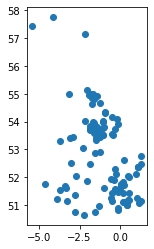

In [23]:
gdf_outages = gpd.GeoDataFrame(
    data=df_outages.drop(columns=['longitude', 'latitude']), 
    geometry=gpd.points_from_xy(df_outages['longitude'], df_outages['latitude']),
    crs='EPSG:4326'
)

gdf_outages.plot()

In [24]:
outages_geojson = json.loads(gdf_outages.to_json(drop_id=True))

JSON(outages_geojson)

<IPython.core.display.JSON object>

In [25]:
rendered_map_js = Template(open('../templates/map_js.j2').read()).render(
    zoom=5,
    center=[53.96, -3.22],
    geojson_features=str(outages_geojson).replace('None', 'null')
)

with open('../docs/map.js', 'w', encoding='utf8') as fp:
    fp.write(rendered_map_js)

In [26]:
df_outages_clean = pd.DataFrame()

df_outages_clean['Incident'] = df_outages.agg(lambda x: f"<a href=\"{x['incident_url']}\" target=\"_blank\">{x['incident_id']}</a>", axis=1)
df_outages_clean['Received Time'] = pd.to_datetime(df_outages['received_time']).dt.strftime('%Y-%m-%d %H:%M').fillna('Unknown')
df_outages_clean['Estimated Restored Time'] = pd.to_datetime(df_outages['estimated_restored_time']).dt.strftime('%Y-%m-%d %H:%M').fillna('Unknown')
df_outages_clean['Postcodes Impacted'] = df_outages['postcodes_impacted'].str.join(', ')
df_outages_clean['Operator'] = df_outages['dno'].str.upper()
df_outages_clean['Description'] = df_outages['description'].str.replace('\n', '<br>')

df_outages_clean = df_outages_clean.sort_values('Received Time', ascending=False)

df_outages_clean.head(3)

,Incident,Received Time,Estimated Restored Time,Postcodes Impacted,Operator,Description
13,"<a href=""https://www.ukpowernetworks.co.uk/pow...",2021-04-09 16:07,2021-04-09 20:30,"TN39PH, TN39QY, TN39QZ, TN39RA, TN39RB, TN39RE...",UKPN,A fault occurred on a piece of our electrical ...
14,"<a href=""https://www.ukpowernetworks.co.uk/pow...",2021-04-09 16:05,2021-04-09 19:30,"E81FG, E81GP, E81NG, E81DB, E81DE, E81DJ, E81P...",UKPN,A fault occurred on a piece of our electrical ...
111,"<a href=""https://www.northernpowergrid.com/pow...",2021-04-09 16:00,2021-04-09 16:00,HD8 9HH,NP,We need to temporarily turn the power off to c...


In [27]:
rendered_index_md = Template(open('../templates/index_md.j2').read()).render(
    map_width='600px',
    map_height='500px',
    md_table=df_outages_clean.to_markdown(index=False)
)

with open('../docs/index.md', 'w', encoding='utf8') as fp:
    fp.write(rendered_index_md)